# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig

@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/8e32860c-clip-b-sae-gated-all-tokens-x64-layer-9-mlp-out-v1/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
# torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [7]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [8]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [9]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/8e32860c-clip-b-sae-gated-all-tokens-x64-layer-9-mlp-out-v1/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

In [10]:
import matplotlib.pyplot as plt

torch.no_grad()
def get_heatmap(
          image,
          model,
          sparse_autoencoder,
          feature_id,
): 
    image = image.to(cfg.device)
    _, cache = model.run_with_cache(image.unsqueeze(0))

    post_reshaped = einops.rearrange(cache[sparse_autoencoder.cfg.hook_point], "batch seq d_mlp -> (batch seq) d_mlp")
    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    sae_in =  post_reshaped - sparse_autoencoder.b_dec # Remove decoder bias as per Anthropic
    acts = einops.einsum(
            sae_in,
            sparse_autoencoder.W_enc[:, feature_id],
            "x d_in, d_in -> x",
        )
    return acts 

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

@torch.no_grad()
def get_feature_probability(images, model, sparse_autoencoder):
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    sae_out, feature_acts, loss, mse_loss, l1_loss, mse_loss_ghost_resid, aux_reconstruction_loss = sparse_autoencoder(
        cache[sparse_autoencoder.cfg.hook_point]
    )

    # Flatten first two dimensions (batch, position) to get a 2D tensor of activations
    return (feature_acts.abs() > 0).float().flatten(0, 1)

def process_dataset(val_dataloader, model, sparse_autoencoder, cfg):
    total_acts = None
    total_tokens = 0
    
    for idx, batch in tqdm(enumerate(val_dataloader), total=cfg.eval_max//cfg.batch_size):
        images = batch[0]

        images = images.to(cfg.device)
        sae_activations = get_feature_probability(images, model, sparse_autoencoder)
        
        if total_acts is None:
            total_acts = sae_activations.sum(0)
        else:
            total_acts += sae_activations.sum(0)
        
        total_tokens += sae_activations.shape[0]
        
        # if total_tokens >= cfg.eval_max:
        #     break
    
    return total_acts, total_tokens

def calculate_log_frequencies(total_acts, total_tokens):
    feature_probs = total_acts / total_tokens
    log_feature_probs = torch.log10(feature_probs)
    return log_feature_probs.cpu().numpy()


# Main execution
total_acts, total_tokens = process_dataset(val_dataloader, model, sparse_autoencoder, cfg)

log_frequencies = calculate_log_frequencies(total_acts, total_tokens)

print(f"Total tokens processed: {total_tokens}")
print(f"Average activations per token: {total_acts.sum().item() / total_tokens:.4f}")

log_freq = torch.Tensor(log_frequencies)

# minimum and maximum log_freq
min_log_freq = log_freq.min().item()
max_log_freq = log_freq.max().item()

print(f"Minimum log frequency: {min_log_freq:.4f}")
print(f"Maximum log frequency: {max_log_freq:.4f}")

1563it [02:08, 12.13it/s]                                                                                                                 

Total tokens processed: 2500000
Average activations per token: 108.6593
Minimum log frequency: -inf
Maximum log frequency: -0.5252


In [12]:

# Define intervals based on the specified ranges
intervals = [
    (-8, -6),
    (-6, -5),
    (-5, -4),
    (-4, -3),
    (-3, -2),
    (-2, -1),
    (-float('inf'), -8),  # This covers the [-8, -4] range and below
    (-1, float('inf'))    # This covers everything above -1
]

conditions = [torch.logical_and(log_freq >= lower, log_freq < upper) for lower, upper in intervals]
condition_texts = [
    f"TOTAL_logfreq_[{lower},{upper}]" for lower, upper in intervals
]

# Replace infinity with appropriate text for readability
condition_texts[-2] = condition_texts[-2].replace('-inf', '-∞')
condition_texts[-1] = condition_texts[-1].replace('inf', '∞')

In [13]:
# get random features from different bins

log_freq = log_freq.to('cuda')

interesting_features_indices = []
interesting_features_values = []
interesting_features_category = []
number_features_per = 500
for condition, condition_text in zip(conditions, condition_texts):
    

    potential_indices = torch.nonzero(condition, as_tuple=True)[0]

    # Shuffle these indices and select a subset
    sampled_indices = potential_indices[torch.randperm(len(potential_indices))[:number_features_per]].to('cuda')
    

    values = log_freq[sampled_indices]

    interesting_features_indices = interesting_features_indices + sampled_indices.tolist()
    interesting_features_values = interesting_features_values + values.tolist()

    interesting_features_category = interesting_features_category + [f"{condition_text}"]*len(sampled_indices)


print(set(interesting_features_category))

{'TOTAL_logfreq_[-8,-6]', 'TOTAL_logfreq_[-4,-3]', 'TOTAL_logfreq_[-∞,-8]', 'TOTAL_logfreq_[-6,-5]', 'TOTAL_logfreq_[-3,-2]', 'TOTAL_logfreq_[-5,-4]', 'TOTAL_logfreq_[-1,∞]', 'TOTAL_logfreq_[-2,-1]'}


In [14]:
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

@torch.no_grad()
def compute_feature_activations_image(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10
) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    
    layer_activations = cache[sparse_autoencoder.cfg.hook_point]
    batch_size, seq_len, _ = layer_activations.shape
    flattened_activations = einops.rearrange(layer_activations, "batch seq d_mlp -> (batch seq) d_mlp")
    
    sae_input = flattened_activations - sparse_autoencoder.b_dec
    feature_activations = einops.einsum(sae_input, encoder_weights, "... d_in, d_in n -> ... n") + encoder_biases
    feature_activations = torch.nn.functional.relu(feature_activations)
    
    
    
    # take the cache and iteratively run, using grad asc. to heighten feature activations
    
    print(f"encoder_weights.shape: {encoder_weights.shape}")
    print(f"feature_activations.shape: {feature_activations.shape}")
    
    reshaped_activations = einops.rearrange(feature_activations, "(batch seq) d_in -> batch seq d_in", batch=batch_size, seq=seq_len)

    return feature_activations

In [15]:
sparse_autoencoder.cfg.hook_point

'blocks.9.hook_mlp_out'

In [14]:
hooklist = []

In [15]:
# a dict to store the activations
activations = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activations[name] = output#.detach()
    return hook

h = model.blocks[9].hook_mlp_out.register_forward_hook(getActivation("uhhh"))
hooklist.append(h)
# use h.remove()

In [16]:
model.blocks[9].hook_mlp_out

HookPoint()

In [17]:
# activations['uhhh'].shape
max_samples = cfg.eval_max

# shape is because we subsampled feats
encoder_biases = sparse_autoencoder.b_enc[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc[:, interesting_features_indices]


In [18]:
for i in range(3):
    res = model(example_image[None,:,:,:].cuda())
    layer_activations = activations['uhhh']
    print(layer_activations)
#     res.sum().backward()
    layer_activations.sum().backward()

NameError: name 'example_image' is not defined

True
tensor(0.1494, device='cuda:0', grad_fn=<SelectBackward0>)


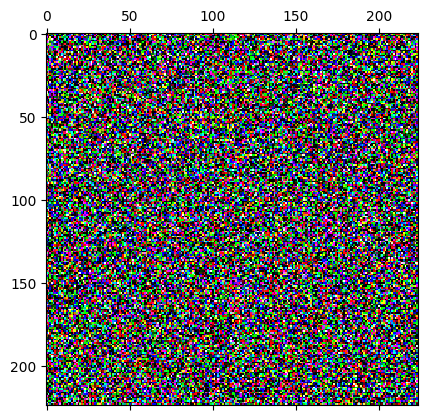

tensor(1.6259, device='cuda:0', grad_fn=<SelectBackward0>)


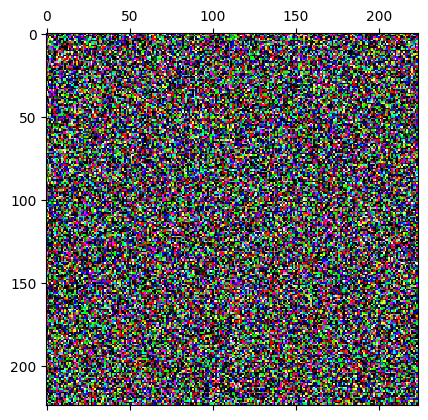

tensor(5.7673, device='cuda:0', grad_fn=<SelectBackward0>)


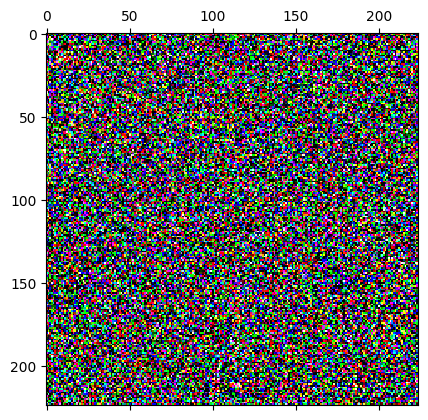

tensor(10.7393, device='cuda:0', grad_fn=<SelectBackward0>)


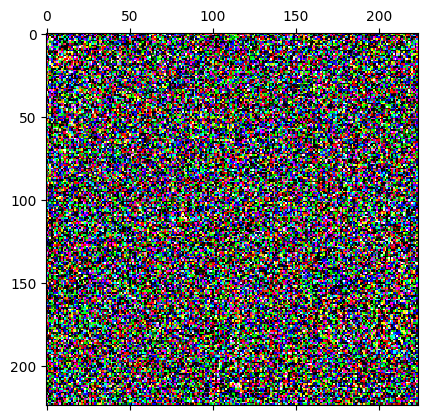

tensor(25.7134, device='cuda:0', grad_fn=<SelectBackward0>)


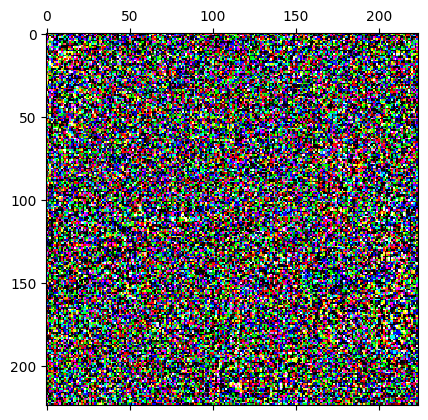

tensor(38.2687, device='cuda:0', grad_fn=<SelectBackward0>)


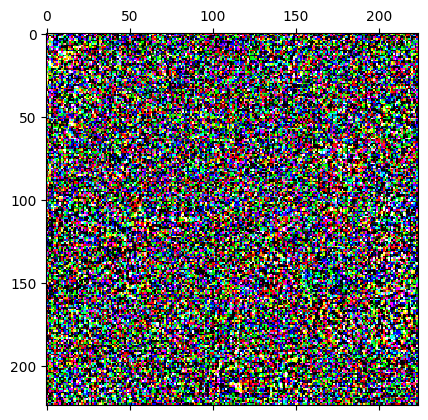

tensor(47.8357, device='cuda:0', grad_fn=<SelectBackward0>)


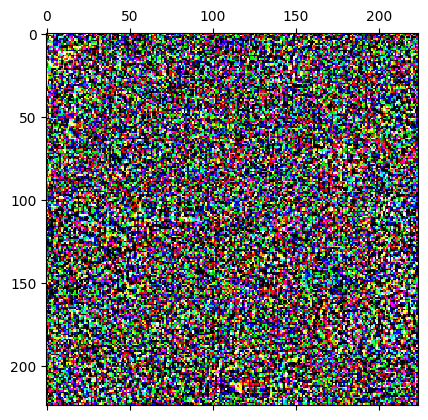

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

example_image = nn.Parameter(torch.normal(0, 1, size=(3, 224, 224)))
print(example_image.requires_grad)
model.eval()

steps = 5000
iters = []
gradnorms = []
# optimizer = torch.optim.SGD([example_image], lr=0.001, momentum=0.9)
for i in range(steps):
    example_image.retain_grad()
    res = model(example_image[None,:,:,:].cuda())
    
    layer_activations = activations['uhhh']
#     print(layer_activations)
    batch_size, seq_len, _ = layer_activations.shape
    flattened_activations = einops.rearrange(layer_activations, "batch seq d_mlp -> (batch seq) d_mlp")
    
    sae_input = flattened_activations - sparse_autoencoder.b_dec
    # something in this line (below) fucks up the gradient
#     print(encoder_weights.shape)
#     feature_activations = sae_input.flatten() @ encoder_weights
    feature_activations = einops.einsum(sae_input, encoder_weights, "... d_in, d_in n -> ... n") + encoder_biases
    feature_activations = torch.nn.functional.relu(feature_activations)

#     print(sae_input.shape)
    (sae_input[0][0] * 10).backward() #retain_graph=True
#     feature_activations.sum().backward() #retain_graph=True
#     layer_activations.sum().backward()
#     print(f"example_image.grad: {example_image.grad}")
    what = example_image.grad
    example_image = example_image + what
    
#     gradnorm = example_image.grad.norm(p=2)
#     gradnorms.append(gradnorm)
#     print(f"example_image.grad norm: {gradnorm}")
    

    if i % 50 == 0:
        print(sae_input[0][0])
        iters.append(example_image.detach())
        plt.matshow(example_image.detach().cpu().permute(1,2,0).numpy())
        plt.show()


In [43]:
gradnorms

[tensor(15.5966),
 tensor(15.5804),
 tensor(15.5493),
 tensor(15.5049),
 tensor(15.4492),
 tensor(15.3852),
 tensor(15.3164),
 tensor(15.2464),
 tensor(15.1776),
 tensor(15.1109),
 tensor(15.0447),
 tensor(14.9755),
 tensor(14.8988),
 tensor(14.8102),
 tensor(14.7073),
 tensor(14.5909),
 tensor(14.4650),
 tensor(14.3366),
 tensor(14.2128),
 tensor(14.0986),
 tensor(13.9960),
 tensor(13.9039),
 tensor(13.8190),
 tensor(13.7379),
 tensor(13.6576),
 tensor(13.5762),
 tensor(13.4933),
 tensor(13.4096),
 tensor(13.3276),
 tensor(13.2516),
 tensor(13.1874),
 tensor(13.1406),
 tensor(13.1138),
 tensor(13.1041),
 tensor(13.1048),
 tensor(13.1075),
 tensor(13.1051),
 tensor(13.0931),
 tensor(13.0696),
 tensor(13.0346),
 tensor(12.9890),
 tensor(12.9353),
 tensor(12.8760),
 tensor(12.8141),
 tensor(12.7520),
 tensor(12.6917),
 tensor(12.6343),
 tensor(12.5799),
 tensor(12.5284),
 tensor(12.4792),
 tensor(12.4317),
 tensor(12.3856),
 tensor(12.3407),
 tensor(12.2972),
 tensor(12.2555),
 tensor(12

In [44]:
for i in range(len(iters)-1):
    print(iters[i] == iters[i+1])

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [23]:
model.training

False

In [24]:
feature_activations[0][-1]

tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)

In [25]:
feature_activations[0][-1].backward(retain_graph=True)

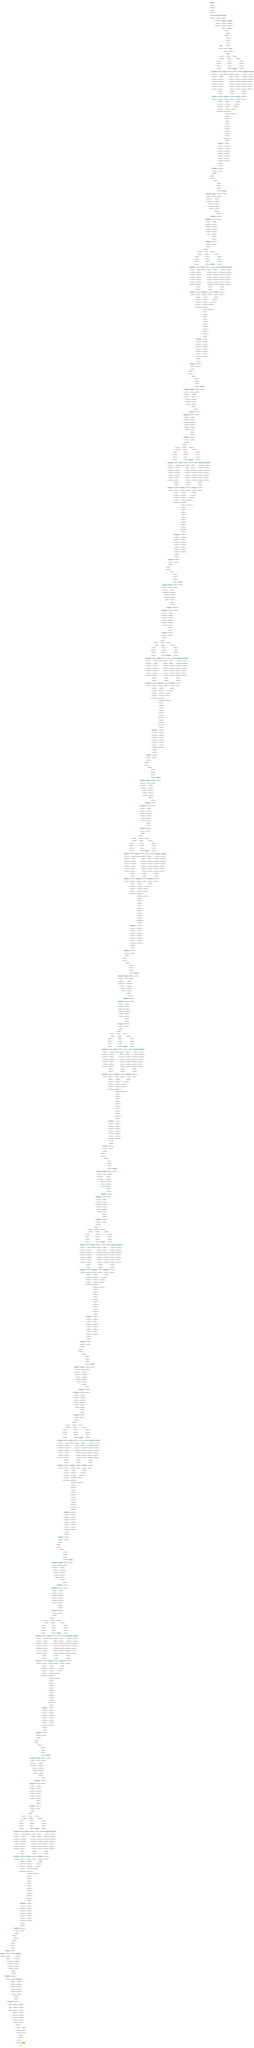

In [68]:
import torchviz
torchviz.make_dot(feature_activations[0][-1], params=dict(model.named_parameters()) )#.render("backward_graph", format="png")

In [38]:
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        print(n)
getBack(feature_activations[0][0].grad_fn)

(<SelectBackward0 object at 0x7b31e211c1c0>, 0)


In [76]:
example_image

Parameter containing:
tensor([[[-0.2917,  2.6357,  4.6646,  ..., -5.4536,  4.3989,  5.2527],
         [ 4.8658,  4.1313,  6.8559,  ...,  1.0548,  5.1441, -0.5079],
         [ 3.5230,  6.2453,  3.6646,  ...,  3.6294,  1.8565,  2.2229],
         ...,
         [ 6.7472,  3.8910,  2.9100,  ..., -0.1174, -1.8249,  4.4714],
         [ 3.7606,  0.7518,  5.2573,  ...,  5.0798,  7.3658,  4.4906],
         [ 4.3439,  0.6786,  0.6569,  ...,  4.8185,  5.2534,  3.5237]],

        [[ 5.7535,  0.7675,  4.2764,  ...,  4.9055,  3.6433,  3.7001],
         [ 6.0452,  0.2099, -3.4089,  ..., -1.7750, -3.9813,  3.3681],
         [ 4.6692,  1.7785,  2.9223,  ...,  1.2863,  1.8002,  0.9503],
         ...,
         [ 4.1239, -2.1602, -1.4032,  ...,  3.0181,  3.5425,  5.4135],
         [10.4834,  5.8996,  0.5273,  ...,  3.4449,  8.3149, -0.2132],
         [ 5.3928,  6.9708,  3.3965,  ...,  4.7330,  6.5383,  4.5646]],

        [[ 4.6341,  3.6349,  1.2212,  ...,  0.6783,  2.1234,  0.6399],
         [ 4.8596, -0.2

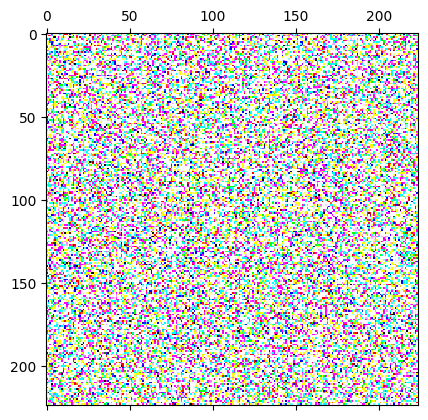

In [79]:

import matplotlib.pyplot as plt
import numpy as np

plt.matshow(example_image.detach().cpu().permute(1,2,0).numpy())

plt.show()


In [30]:
print(example_image.grad)

None


In [45]:
max_samples = cfg.eval_max

top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc[:, interesting_features_indices]

model.eval()

processed_samples = 0
feature_activations = compute_feature_activations_image(
    example_image[None,:,:,:].cuda(), model, sparse_autoencoder, encoder_weights, encoder_biases,
    interesting_features_indices, interesting_features_category
)

feature_activations[0][0].backward()

encoder_weights.shape: torch.Size([768, 3187])
feature_activations.shape: torch.Size([50, 3187])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [44]:
feature_activations[0][0]

tensor(0.0178, device='cuda:0')

In [33]:
example_image.requires_grad

True

In [16]:
batch_activations

{7993: (tensor([17, 25,  0, 30,  4,  5, 19, 18, 16, 29], device='cuda:0'),
  tensor([0.0028, 0.0025, 0.0023, 0.0023, 0.0022, 0.0022, 0.0022, 0.0022, 0.0020,
          0.0016], device='cuda:0')),
 44629: (tensor([17, 29, 25, 16, 19, 11,  0, 14,  8,  6], device='cuda:0'),
  tensor([0.0019, 0.0016, 0.0016, 0.0015, 0.0014, 0.0012, 0.0011, 0.0009, 0.0009,
          0.0009], device='cuda:0')),
 44450: (tensor([17, 11,  5, 29, 16, 12, 25, 15,  9,  6], device='cuda:0'),
  tensor([0.0028, 0.0018, 0.0015, 0.0014, 0.0014, 0.0011, 0.0010, 0.0009, 0.0009,
          0.0008], device='cuda:0')),
 33635: (tensor([ 2, 18, 11, 25,  4, 12,  5, 29, 17,  8], device='cuda:0'),
  tensor([0.0030, 0.0012, 0.0011, 0.0011, 0.0009, 0.0007, 0.0006, 0.0006, 0.0004,
          0.0004], device='cuda:0')),
 44099: (tensor([18, 11, 14, 24, 25, 29, 15, 17,  5, 23], device='cuda:0'),
  tensor([0.0027, 0.0022, 0.0019, 0.0018, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014,
          0.0014], device='cuda:0')),
 42024: (tensor([29, 

In [ ]:
# might be useful late

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# import torch
# import torch.optim as optim



# class SAETokens(nn.Module):
#     def __init__(self, encoder_weights: torch.Tensor):
#         super(SAETokens, self).__init__()
#         self.feat_dim = encoder_weights.shape[0]
#         self.num_feats = encoder_weights.shape[1]
#         self.feats = nn.Parameter(torch.zeros((self.num_feats, self.feat_dim)))
        
#     def forward(self, x):
#         # better be nf, fd @ fd, nf
#         return torch.matmul(torch.nn.functional.softmax(self.feats), x)


# # PyTorch models inherit from torch.nn.Module
# def get_maximally_activ_feat_input(sparse_autoencoder: torch.nn.Module,
#                             encoder_weights: torch.Tensor,
#                             encoder_biases: torch.Tensor,
#                             steps=100,
#                            ):
#         # encoder_weights should be d_input, d_sae
#     feat_dim = encoder_weights.shape[0]
#     num_feats = encoder_weights.shape[1]
# #     self.feat_tokens = nn.ModuleList([torch.zeros(self.feat_dim, requires_grad=True), for i in range(self.num_feats)])
#     feat_tokens = SAETokens(encoder_weights)
#     feat_tokens.train()
    
#     print(feat_tokens.feats.shape)
#     print(feat_tokens.feats.requires_grad)
    
#     model_input = torch.ones((feat_dim, feat_dim))
    
#     out = feat_tokens(model_input)
#     print(out.shape)
    
#     for i in range(out.shape[0]):
#         print(out.requires_grad)
#         loss = -torch.norm(out, p=2, dim=1)
#         print(loss.shape)
#         print(loss.requires_grad)
#         loss[i].backward()

#         break
#     return

#     for i in range(steps):
#         batch_sae_input = self.feat_tokens - self.sparse_autoencoder.b_dec
        
#         for token_idx, token in enumerate(self.feat_tokens):
#             # pass all tokens through SAE
#             feature_activations = einops.einsum(self.sae_input, self.encoder_weights, "... d_in, d_in n -> ... n") + self.encoder_biases
#             feature_activations = torch.nn.functional.relu(feature_activations)
#             feature_activations[token_idx].backward(retain_graph=True)
#         return feature_activations

# encoder_biases = sparse_autoencoder.b_enc[interesting_features_indices]
# encoder_weights = sparse_autoencoder.W_enc[:, interesting_features_indices]
# get_maximally_activ_feat_input(sparse_autoencoder,
#                                encoder_weights,
#                                encoder_biases)